<a href="https://colab.research.google.com/github/JhonaGo/ETLS/blob/main/Hierarchical_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick Start

> Minimal Example of Hierarchical Reconciliation

Large collections of time series organized into structures at different aggregation levels often require their forecasts to follow their aggregation constraints, which poses the challenge of creating novel algorithms capable of coherent forecasts.

The `HierarchicalForecast` package provides a wide collection of Python implementations of hierarchical forecasting algorithms that follow classic hierarchical reconciliation.

In this notebook we will show how to use the `StatsForecast` library to produce base forecasts, and use `HierarchicalForecast` package to perform hierarchical reconciliation.

You can run these experiments using CPU or GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/TourismSmall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [ ]:
%%capture
!pip install hierarchicalforecast statsforecast datasetsforecast

## 2. Load Data

In this example we will use the `TourismSmall` dataset. The following cell gets the time series for the different levels in the hierarchy, the summing matrix `S` which recovers the full dataset from the bottom level hierarchy and the indices of each hierarchy denoted by `tags`.

In [ ]:
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo

In [ ]:
group_name = 'TourismSmall'
group = HierarchicalInfo.get_group(group_name)
Y_df, S_df, tags = HierarchicalData.load('./data', group_name)
S_df = S_df.reset_index(names="unique_id")
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

100%|██████████| 1.30M/1.30M [00:00<00:00, 43.1MiB/s]
100%|██████████| 335k/335k [00:00<00:00, 36.7MiB/s]
100%|██████████| 968k/968k [00:00<00:00, 11.2MiB/s]


In [ ]:
S_df.iloc[:6, :6]

,unique_id,nsw-hol-city,nsw-hol-noncity,vic-hol-city,vic-hol-noncity,qld-hol-city
0,total,1.0,1.0,1.0,1.0,1.0
1,hol,1.0,1.0,1.0,1.0,1.0
2,vfr,0.0,0.0,0.0,0.0,0.0
3,bus,0.0,0.0,0.0,0.0,0.0
4,oth,0.0,0.0,0.0,0.0,0.0
5,nsw-hol,1.0,1.0,0.0,0.0,0.0


In [ ]:
tags

{'Country': array(['total'], dtype=object),
 'Country/Purpose': array(['hol', 'vfr', 'bus', 'oth'], dtype=object),
 'Country/Purpose/State': array(['nsw-hol', 'vic-hol', 'qld-hol', 'sa-hol', 'wa-hol', 'tas-hol',
        'nt-hol', 'nsw-vfr', 'vic-vfr', 'qld-vfr', 'sa-vfr', 'wa-vfr',
        'tas-vfr', 'nt-vfr', 'nsw-bus', 'vic-bus', 'qld-bus', 'sa-bus',
        'wa-bus', 'tas-bus', 'nt-bus', 'nsw-oth', 'vic-oth', 'qld-oth',
        'sa-oth', 'wa-oth', 'tas-oth', 'nt-oth'], dtype=object),
 'Country/Purpose/State/CityNonCity': array(['nsw-hol-city', 'nsw-hol-noncity', 'vic-hol-city',
        'vic-hol-noncity', 'qld-hol-city', 'qld-hol-noncity',
        'sa-hol-city', 'sa-hol-noncity', 'wa-hol-city', 'wa-hol-noncity',
        'tas-hol-city', 'tas-hol-noncity', 'nt-hol-city', 'nt-hol-noncity',
        'nsw-vfr-city', 'nsw-vfr-noncity', 'vic-vfr-city',
        'vic-vfr-noncity', 'qld-vfr-city', 'qld-vfr-noncity',
        'sa-vfr-city', 'sa-vfr-noncity', 'wa-vfr-city', 'wa-vfr-noncity',
     

We split the dataframe in train/test splits.

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(group.horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

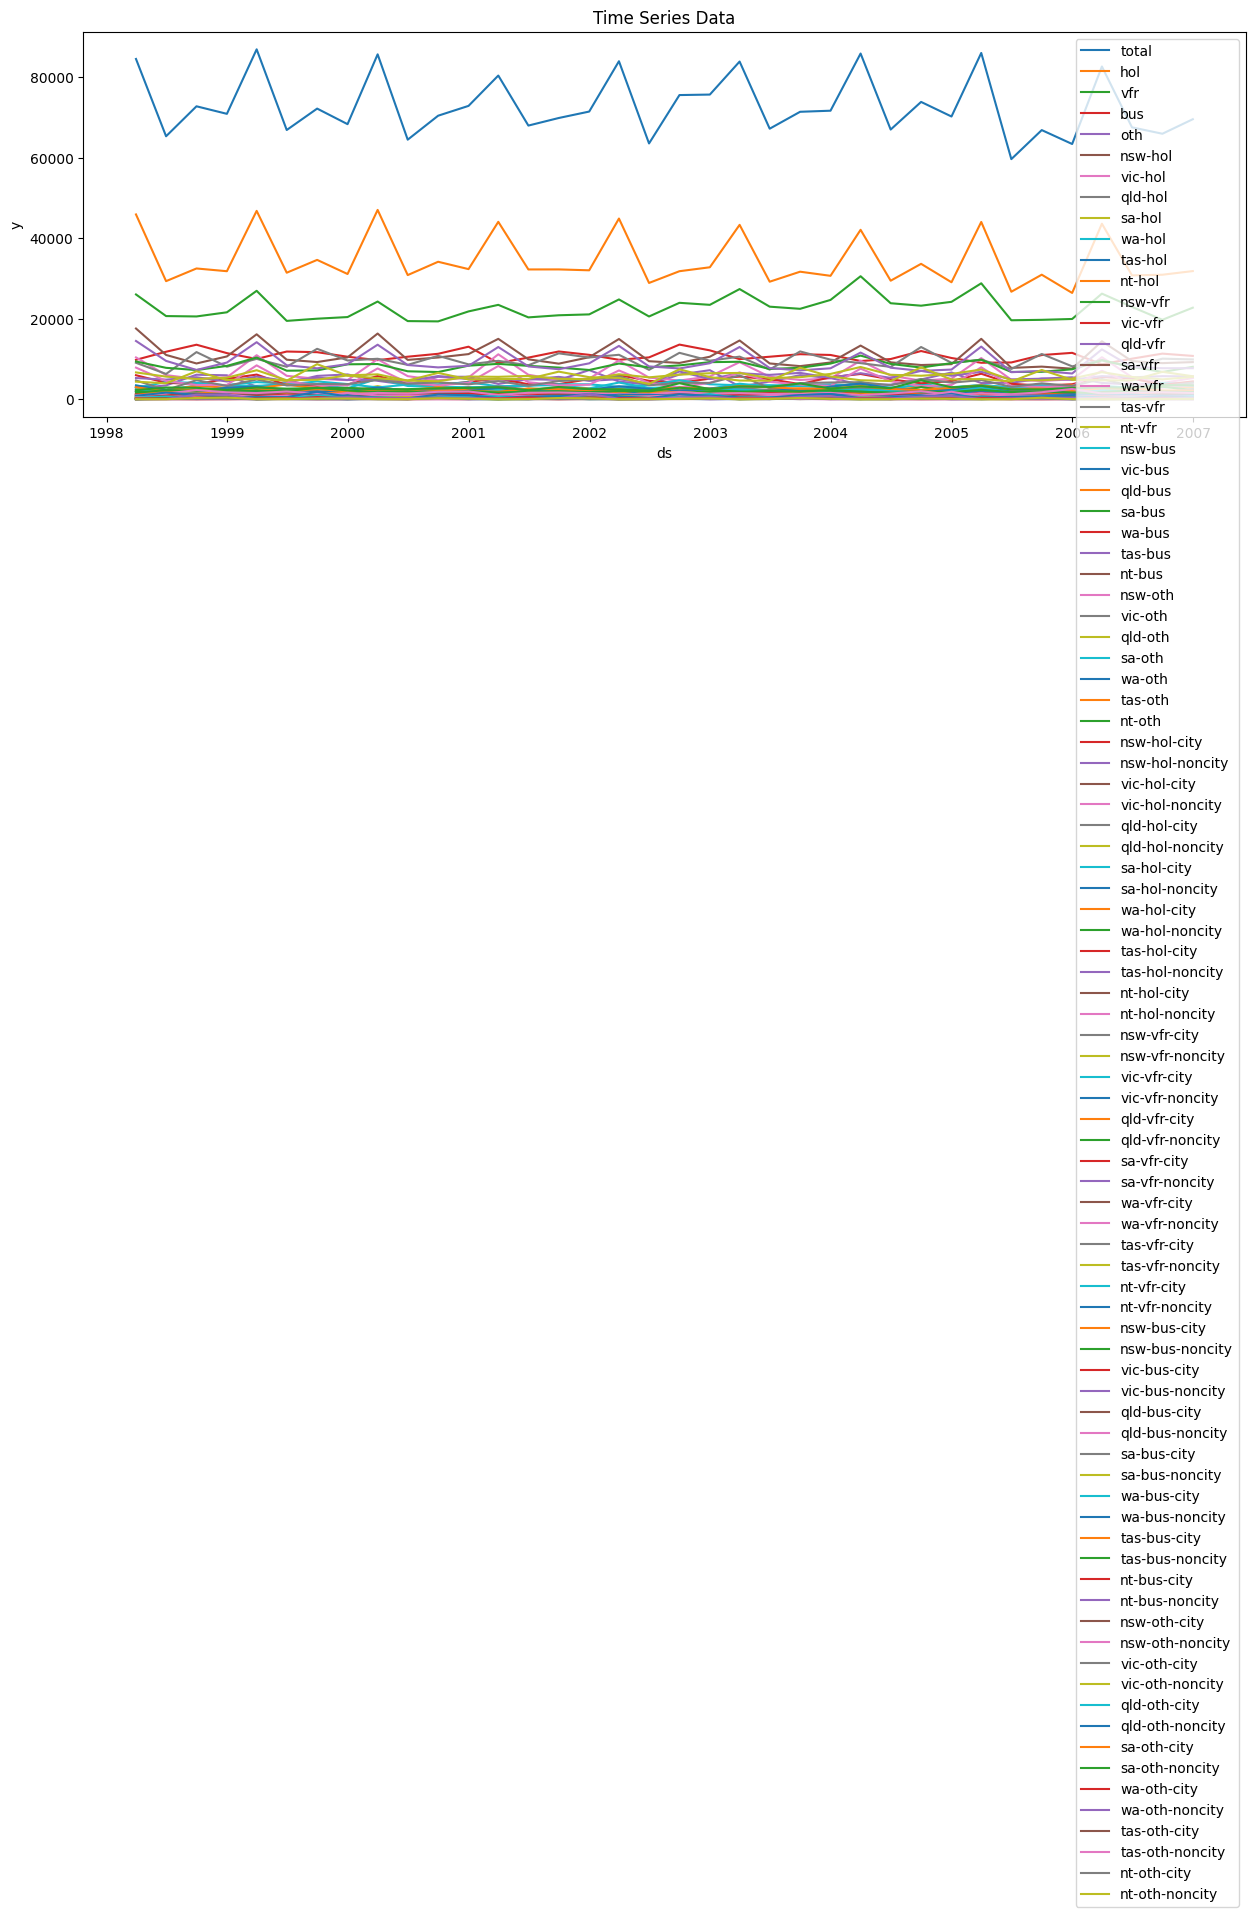

In [ ]:
import matplotlib.pyplot as plt

# plot Y_df
Y_df = pd.concat([Y_train_df, Y_test_df])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 5))

# Iterate through unique_ids and plot each time series
for unique_id in Y_df['unique_id'].unique():
    subset_df = Y_df[Y_df['unique_id'] == unique_id]
    ax.plot(subset_df['ds'], subset_df['y'], label=unique_id)

# Add legend and labels
ax.legend()
ax.set_xlabel('ds')
ax.set_ylabel('y')
ax.set_title('Time Series Data')

# Show the plot
plt.show()

## 3. Base forecasts

The following cell computes the *base forecast* for each time series using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive

In [ ]:
fcst = StatsForecast(
    models=[AutoARIMA(season_length=group.seasonality), Naive()],
    freq="QE",
    n_jobs=-1
)
Y_hat_df = fcst.forecast(df=Y_train_df, h=group.horizon)

## 4. Hierarchical reconciliation

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. The used methods to make the forecasts coherent are:

- `BottomUp`: The reconciliation of the method is a simple addition to the upper levels.
- `TopDown`: The second method constrains the base-level predictions to the top-most aggregate-level serie and then distributes it to the disaggregate series through the use of proportions.
- `MiddleOut`: Anchors the base predictions in a middle level.

In [ ]:
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut

In [ ]:
reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    TopDown(method='proportion_averages'),
    MiddleOut(middle_level="Country/Purpose/State", top_down_method="proportion_averages"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df, S=S_df, tags=tags)

In [ ]:
Y_rec_df.tail()

,unique_id,ds,AutoARIMA,Naive,AutoARIMA/BottomUp,Naive/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,Naive/TopDown_method-forecast_proportions,AutoARIMA/TopDown_method-proportion_averages,Naive/TopDown_method-proportion_averages,AutoARIMA/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages,Naive/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages
351,nt-oth-city,2006-12-31,103.004616,49.0,103.004616,49.0,151.886850,49.0,93.398128,87.805177,118.863560,45.399844
352,nt-oth-noncity,2006-03-31,10.252673,59.0,10.252673,59.0,1.249987,59.0,164.076450,121.071291,7.837451,62.600156
353,nt-oth-noncity,2006-06-30,39.563168,59.0,39.563168,59.0,35.688606,59.0,122.198032,121.071291,70.090346,62.600156
354,nt-oth-noncity,2006-09-30,283.413483,59.0,283.413483,59.0,310.417603,59.0,135.570897,121.071291,224.113449,62.600156
355,nt-oth-noncity,2006-12-31,106.869293,59.0,106.869293,59.0,157.585562,59.0,128.783204,121.071291,163.896541,62.600156


## 5. Evaluation

The `HierarchicalForecast` package includes the `evaluate` function to evaluate the different hierarchies and we can use utilsforecast to compute the mean absolute error relative to a baseline model.

In [ ]:
from hierarchicalforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae

In [ ]:
df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'])

evaluation = evaluate(df = df,
                      tags = tags,
                      train_df = Y_train_df,
                      metrics = [mse,mae],
                      benchmark="Naive")

evaluation.set_index(["level", "metric"]).filter(like="ARIMA", axis=1)

AutoARIMA  AutoARIMA/BottomUp  \
level                             metric                                      
Country                           mse-scaled   0.123161            0.055264   
                                  mae-scaled   0.435655            0.285730   
Country/Purpose                   mse-scaled   0.171063            0.077688   
                                  mae-scaled   0.423377            0.325079   
Country/Purpose/State             mse-scaled   0.194383            0.149163   
                                  mae-scaled   0.559646            0.466390   
Country/Purpose/State/CityNonCity mse-scaled   0.170373            0.170373   
                                  mae-scaled   0.521432            0.521432   
Overall                           mse-scaled   0.154912            0.085342   
                                  mae-scaled   0.496149            0.423501   

                                              AutoARIMA/TopDown_method-forecast_proportions  \
level                             metric                                                      
Country                           mse-scaled                                       0.123161   
                                  mae-scaled                                       0.435655   
Country/Purpose                   mse-scaled                                       0.101570   
                                  mae-scaled                                       0.394861   
Country/Purpose/State             mse-scaled                                       0.201738   
                                  mae-scaled                                       0.550773   
Country/Purpose/State/CityNonCity mse-scaled                                       0.210060   
                                  mae-scaled                                       0.588008   
Overall                           mse-scaled                                       0.131308   
                                  mae-scaled                                       0.507954   

                                              AutoARIMA/TopDown_method-proportion_averages  \
level                             metric                                                     
Country                           mse-scaled                                      0.123161   
                                  mae-scaled                                      0.435655   
Country/Purpose                   mse-scaled                                      0.128151   
                                  mae-scaled                                      0.423321   
Country/Purpose/State             mse-scaled                                      0.327854   
                                  mae-scaled                                      0.672668   
Country/Purpose/State/CityNonCity mse-scaled                                      0.341365   
                                  mae-scaled                                      0.707622   
Overall                           mse-scaled                                      0.168269   
                                  mae-scaled                                      0.588718   

                                              AutoARIMA/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages  
level                             metric                                                                                                  
Country                           mse-scaled                                           0.079278                                           
                                  mae-scaled                                           0.312261                                           
Country/Purpose                   mse-scaled                                           0.104186                                           
                                  mae-scaled                                           0.359392                                     

## Prediction (production)

In [ ]:
# predict 24 months laters
fcst = StatsForecast(
    models=[AutoARIMA(season_length=group.seasonality), Naive()],
    freq="QE",
    n_jobs=-1
)
pred = fcst.forecast(df=Y_train_df, h=24)
pred

,unique_id,ds,AutoARIMA,Naive
0,bus,2006-03-31,8918.478516,11547.0
1,bus,2006-06-30,9581.925781,11547.0
2,bus,2006-09-30,11194.676758,11547.0
3,bus,2006-12-31,10678.958008,11547.0
4,bus,2007-03-31,8732.233398,11547.0
...,...,...,...,...
2131,wa-vfr-noncity,2010-12-31,859.472229,745.0
2132,wa-vfr-noncity,2011-03-31,859.472229,745.0
2133,wa-vfr-noncity,2011-06-30,859.472229,745.0
2134,wa-vfr-noncity,2011-09-30,859.472229,745.0


In [ ]:
# last date
pred['ds'].unique()

<DatetimeArray>
['2006-03-31 00:00:00', '2006-06-30 00:00:00', '2006-09-30 00:00:00',
 '2006-12-31 00:00:00', '2007-03-31 00:00:00', '2007-06-30 00:00:00',
 '2007-09-30 00:00:00', '2007-12-31 00:00:00', '2008-03-31 00:00:00',
 '2008-06-30 00:00:00', '2008-09-30 00:00:00', '2008-12-31 00:00:00',
 '2009-03-31 00:00:00', '2009-06-30 00:00:00', '2009-09-30 00:00:00',
 '2009-12-31 00:00:00', '2010-03-31 00:00:00', '2010-06-30 00:00:00',
 '2010-09-30 00:00:00', '2010-12-31 00:00:00', '2011-03-31 00:00:00',
 '2011-06-30 00:00:00', '2011-09-30 00:00:00', '2011-12-31 00:00:00']
Length: 24, dtype: datetime64[ns]

In [ ]:
reconcilers = [
    BottomUp(),
    TopDown(method='forecast_proportions'),
    TopDown(method='proportion_averages'),
    MiddleOut(middle_level="Country/Purpose/State", top_down_method="proportion_averages"),
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=pred, Y_df=Y_train_df, S=S_df, tags=tags)

In [ ]:
Y_rec_df

,unique_id,ds,AutoARIMA,Naive,AutoARIMA/BottomUp,Naive/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,Naive/TopDown_method-forecast_proportions,AutoARIMA/TopDown_method-proportion_averages,Naive/TopDown_method-proportion_averages,AutoARIMA/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages,Naive/MiddleOut_middle_level-Country/Purpose/State_top_down_method-proportion_averages
0,total,2006-03-31,85909.171875,63392.0,83511.540324,63392.0,85909.171875,63392.0,85909.171875,63392.000000,83060.424417,63392.000000
1,total,2006-06-30,63981.953125,63392.0,64479.879482,63392.0,63981.953125,63392.0,63981.953125,63392.000000,63271.396461,63392.000000
2,total,2006-09-30,70983.882812,63392.0,68372.778748,63392.0,70983.882812,63392.0,70983.882812,63392.000000,67682.483780,63392.000000
3,total,2006-12-31,67429.898438,63392.0,66731.940979,63392.0,67429.898438,63392.0,67429.898438,63392.000000,65948.037781,63392.000000
4,total,2007-03-31,85958.171875,63392.0,83249.303703,63392.0,85958.171875,63392.0,85958.171875,63392.000000,83540.774940,63392.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2131,nt-oth-noncity,2010-12-31,91.358025,59.0,91.358025,59.0,85.357595,59.0,126.267799,121.071291,88.160687,62.600156
2132,nt-oth-noncity,2011-03-31,9.395120,59.0,9.395120,59.0,4.912926,59.0,164.139521,121.071291,33.233987,62.600156
2133,nt-oth-noncity,2011-06-30,39.348782,59.0,39.348782,59.0,34.183303,59.0,118.889817,121.071291,67.723080,62.600156
2134,nt-oth-noncity,2011-09-30,331.222107,59.0,331.222107,59.0,397.567901,59.0,132.420352,121.071291,278.606181,62.600156


### References
- [Orcutt, G.H., Watts, H.W., & Edwards, J.B.(1968). Data aggregation and information loss. The American
Economic Review, 58 , 773(787)](http://www.jstor.org/stable/1815532).
- [Disaggregation methods to expedite product line forecasting. Journal of Forecasting, 9 , 233–254.
doi:10.1002/for.3980090304](https://onlinelibrary.wiley.com/doi/abs/10.1002/for.3980090304).<br>
- [An investigation of aggregate variable time series forecast strategies with specific subaggregate
time series statistical correlation. Computers and Operations Research, 26 , 1133–1149.
doi:10.1016/S0305-0548(99)00017-9](https://doi.org/10.1016/S0305-0548(99)00017-9).
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition:
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)